# Predictive Analysis - Parks and Arrests

#### Elise Chessman

**Research questions:** Are drug related arrests more prevalent in and near parks? Does the race of the census tract or the location of the park influence whether there will be drug related arrests?

The aim of this predictive model will be to see if proximity to a park, the park name, and census tract race information from the American Community Survey influence the prediction of drug related arrests in New York City. We would assume that people are more likely to be criminalized for drug related arrests in non-white neighborhoods and that parks in these neighborhoods are more likely to be policed. 

After exploring the census data, park data, and NYPD arrest data, it appears as if there is not much of a relationship between parks and the type of arrests that occur. Next, we will focus on if demographic factors of the neigbhorhoods where the arrests occur that are also close to parks might influence if the model predicts arrests, specifically drug related. First I'll bring in my dataframe of arrests from the NYPD for all of 2021, with a boolean column of whether or not those arrests occurred within 100m of a park. 

**Data sources:** [NYPD 2021 Arrests](https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc). [open space data](https://data.cityofnewyork.us/Recreation/Open-Space-Parks-/g84h-jbjm)  from NYC Open Data and 2020 American Community Survey [ACS](https://data.census.gov/cedsci/table?hidePreview=true&tid=ACSDT5Y2020.B03002_).

In [1]:
import pandas as pd
import geopandas as gpd
import requests
import json
import contextily as ctx
import matplotlib.pyplot as plt

This is the same arrests dataset, but with a boolean column of if the arrest occurred within 100m of a park.

In [2]:
parkarrests = pd.read_pickle('../NYCParks-SAEC/parkarrests.pandas')

parkarrests = gpd.GeoDataFrame(parkarrests, 
                        geometry = gpd.points_from_xy(
                         parkarrests.longitude, 
                         parkarrests.latitude, crs='EPSG:4326'))
pd.set_option('display.max_columns', None)

parkarrests = parkarrests.rename(columns={'index_right':'old'})
parkarrests


arrest_key              arrest_date pd_cd  \
0       238013474  2021-12-18T00:00:00.000   157   
8       233697123  2021-09-17T00:00:00.000   157   
13      230822460  2021-07-14T00:00:00.000   168   
20      224595667  2021-02-19T00:00:00.000   153   
202     237429832  2021-12-06T00:00:00.000   205   
...           ...                      ...   ...   
135134  222855064  2021-01-09T00:00:00.000    29   
138006  223833241  2021-02-02T00:00:00.000   339   
141470  222479318  2021-01-01T00:00:00.000   198   
148850  223872256  2021-02-03T00:00:00.000   268   
152105  223531343  2021-01-25T00:00:00.000   259   

                                 pd_desc  ky_cd  \
0                                 RAPE 1  104.0   
8                                 RAPE 1  104.0   
13                              SODOMY 1  116.0   
20                                RAPE 3  104.0   
202                 TRESPASS 2, CRIMINAL  352.0   
...                                  ...    ...   
135134              NYS PAROLE VIOLATION  995.0   
138006    LARCENY,PETIT FROM OPEN AREAS,  341.0   
141470               CRIMINAL CONTEMPT 1  126.0   
148850                CRIMINAL MIS 2 & 3  121.0   
152105  CRIMINAL MISCHIEF,UNCLASSIFIED 4  351.0   

                             ofns_desc    law_code law_cat_cd arrest_boro  \
0                                 RAPE  PL 1303501          F           Q   
8                                 RAPE  PL 1303501          F           Q   
13                          SEX CRIMES  PL 1305001          F           Q   
20                                RAPE  PL 1302502          F           Q   
202                  CRIMINAL TRESPASS  PL 1401501          M           Q   
...                                ...         ...        ...         ...   
135134           FOR OTHER AUTHORITIES  FOA9000029        NaN           K   
138006                   PETIT LARCENY  PL 1552500          M           Q   
141470         MISCELLANEOUS PENAL LAW  PL 21551B2          F           Q   
148850  CRIMINAL MISCHIEF & RELATED OF  PL 1451000          F           M   
152105  CRIMINAL MISCHIEF & RELATED OF  PL 1450001          M           M   

       arrest_precinct jurisdiction_code age_group perp_sex       perp_race  \
0                  105                97     18-24        M           BLACK   
8                  105                 0     25-44        M           BLACK   
13                 105                 0     45-64        M           BLACK   
20                 105                 0     25-44        M           BLACK   
202                105                 0     25-44        M           BLACK   
...                ...               ...       ...      ...             ...   
135134              76                 0     25-44        M           BLACK   
138006             100                 0     18-24        M           WHITE   
141470             100                 0     25-44        M           WHITE   
148850              34                 0     18-24        M  BLACK HISPANIC   
152105              34                 0     45-64        M           WHITE   

       x_coord_cd y_coord_cd            latitude           longitude  \
0         1057636     203954   40.72618713000002  -73.73523390399998   
8         1057636     203954   40.72618713000002  -73.73523390399998   
13        1057636     203954   40.72618713000002  -73.73523390399998   
20        1057636     203954   40.72618713000002  -73.73523390399998   
202       1055501     197102  40.707397564000075  -73.74300919899997   
...           ...        ...                 ...                 ...   
135134     981936     184577   40.67330588400005  -74.00834343599996   
138006    1031835     151473   40.58231495500007  -73.82869068099996   
141470    1026027     150171  40.578770500000076  -73.84960806399994   
148850    1006093     255796   40.86875668900007  -73.92102578399994   
152105    1006093     255796   40.86875668900007  -73.92102578399994   

                              

In [3]:
requestString = 'https://data.cityofnewyork.us/resource/4j29-i5ry.geojson'
parkgdf = gpd.read_file(requestString)


Text(0.5, 1.0, 'NYC Park Locations and NYPD Arrests 2021')

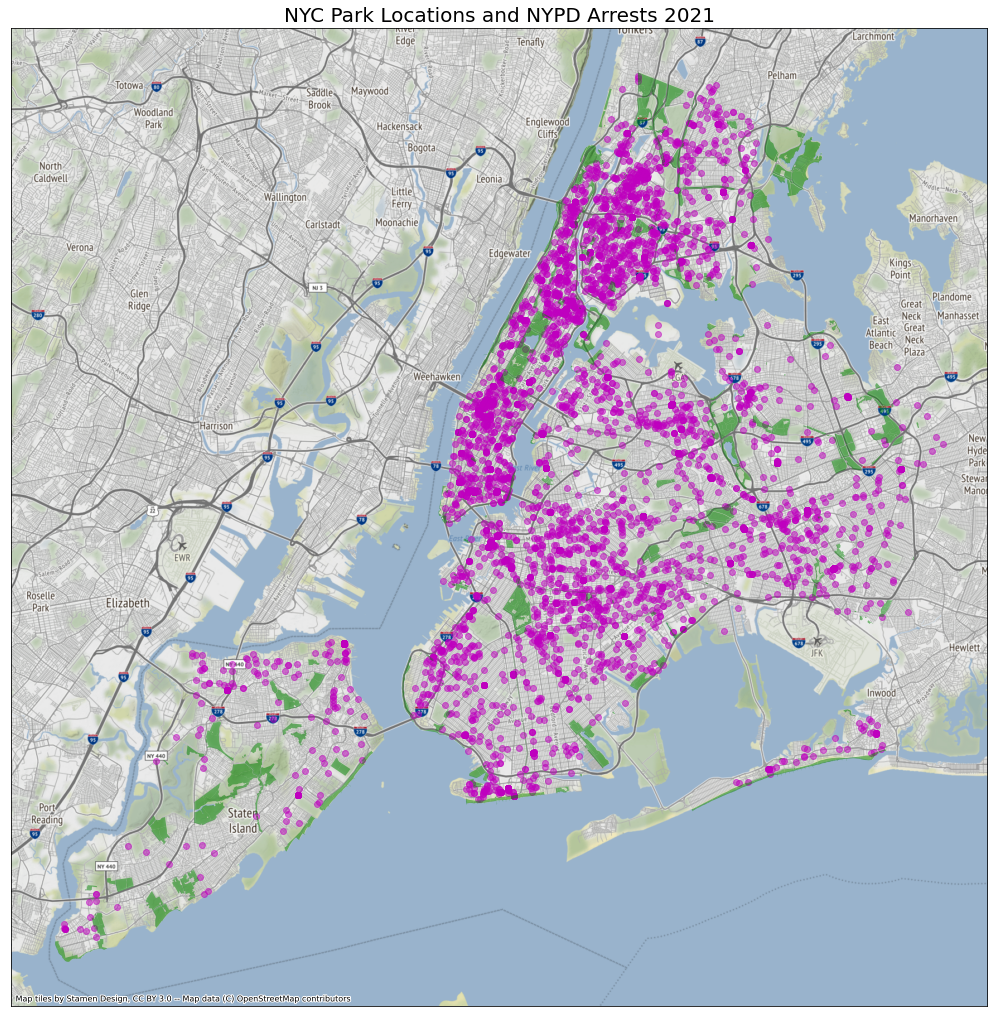

In [4]:
fig, ax = plt.subplots(figsize=(18,18))
parkarrests.sample(5000).to_crs('EPSG:3857').plot(color='m', alpha=0.5, ax=ax) 
parkgdf.to_crs('EPSG:3857').plot(color='g', alpha=0.5, ax=ax)


ctx.add_basemap(ax, zoom=12)

ax.set_xticks([])
ax.set_yticks([])
plt.title("NYC Park Locations and NYPD Arrests 2021",fontdict={'fontsize': 20})

## Bringing in the Census Data

Steph nicely cleaned the census data and created race percentage columns by census tract level using ACS data for New York City, so we'll bring that in as a Geopackage. 

In [5]:
race_Df = gpd.read_file('../NYCParks-SAEC/race_Df_clean.gpkg')

## Spatial Joining Census and Arrest Data

#### Elise Chessman

Next, I'll join the parks and the census data to look at how race at the census tract level influences the predicted park arrests.

In [6]:
parkarrests.to_crs('EPSG:4326', inplace=True)
race_Df.to_crs('EPSG:4326', inplace=True)

In [7]:
allgdf = gpd.sjoin(race_Df, parkarrests, how='left', predicate='intersects')

In [8]:
allgdf = allgdf.reset_index(drop=True)

From my previous data exploration looking at the type of arrests that happen near parks vs. the arrest dataset broadly, I found that there was generally very little difference between the arrests close to parks and the entire arrest dataset when it comes to the type of arrests that happen. One that did increase was the percentage of dangerous drug arrests (7.6% of  arrests near parks in 2021 as opposed to 6.7% for the arrests overall). So next I'll use arrests near parks as my total dataset to try to predict drug related arrests near parks and to see if those arrests are influenced by the race of the census tract.

In [9]:
allgdf['drug_offense']=allgdf.ofns_desc=='DANGEROUS DRUGS'
allgdf

geoid                             name   Total  White  \
0       14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
1       14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
2       14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
3       14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
4       14000US36005000100        Census Tract 1, Bronx, NY  6600.0  817.0   
...                    ...                              ...     ...    ...   
155515  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
155516  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
155517  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
155518  14000US36085032300   Census Tract 323, Richmond, NY  1200.0  135.0   
155519  14000US36085990100  Census Tract 9901, Richmond, NY     0.0    0.0   

         Black  American Indian and Alaska Native  Asian  Pacific Islander  \
0       3234.0                               27.0  171.0               0.0   
1       3234.0                               27.0  171.0               0.0   
2       3234.0                               27.0  171.0               0.0   
3       3234.0                               27.0  171.0               0.0   
4       3234.0                               27.0  171.0               0.0   
...        ...                                ...    ...               ...   
155515   411.0                                0.0   15.0               0.0   
155516   411.0                                0.0   15.0               0.0   
155517   411.0                                0.0   15.0               0.0   
155518   411.0                                0.0   15.0               0.0   
155519     0.0                                0.0    0.0               0.0   

        Other Race  Two or more races  Hispanic  Percent_White  Percent_Black  \
0              0.0               36.0    2315.0      12.378788          49.00   
1              0.0               36.0    2315.0      12.378788          49.00   
2              0.0               36.0    2315.0      12.378788          49.00   
3              0.0               36.0    2315.0      12.378788          49.00   
4              0.0               36.0    2315.0      12.378788          49.00   
...            ...                ...       ...            ...            ...   
155515        17.0              234.0     388.0      11.250000          34.25   
155516        17.0              234.0     388.0      11.250000          34.25   
155517        17.0              234.0     388.0      11.250000          34.25   
155518        17.0              234.0     388.0      11.250000          34.25   
155519         0.0                0.0       0.0            NaN            NaN   

        Percent_American_Indian_and_Alaska Native  Percent_Asian  \
0                                        0.409091       2.590909   
1                                        0.409091       2.590909   
2                                        0.409091       2.590909   
3                                        0.409091       2.590909   
4                                        0.409091       2.590909   
...                                           ...            ...   
155515                                   0.000000       1.250000   
155516                                   0.000000       1.250000   
155517                                   0.000000       1.250000   
155518                                   0.000000       1.250000   
155519                                        NaN            NaN   

        Percent_Pacific_Islander  Percent_Other_Race  \
0                            0.0            0.000000   
1                            0.0            0.000000   
2                            0.0            0.000000   
3                            0.0            0.000000   
4                            0.0            0.000000   
...                  

Next I created a column that combines the drug offense and distance to park boolean columns. Used & to combine the boolean columns (more about that here: https://stackoverflow.com/questions/21415661/logical-operators-for-boolean-indexing-in-pandas)
    

In [10]:
allgdf['park_drug'] =  (allgdf.hundred_m) & (allgdf.drug_offense)
allgdf.sample(20)
allgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 155520 entries, 0 to 155519
Data columns (total 69 columns):
 #   Column                                     Non-Null Count   Dtype   
---  ------                                     --------------   -----   
 0   geoid                                      155520 non-null  object  
 1   name                                       155520 non-null  object  
 2   Total                                      155520 non-null  float64 
 3   White                                      155520 non-null  float64 
 4   Black                                      155520 non-null  float64 
 5   American Indian and Alaska Native          155520 non-null  float64 
 6   Asian                                      155520 non-null  float64 
 7   Pacific Islander                           155520 non-null  float64 
 8   Other Race                                 155520 non-null  float64 
 9   Two or more races                          155520 non-null  fl

## Predicting Drug Related Arrests Around Parks

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['Percent_Black','Percent_Hispanic','Percent_White',]
yvar = 'park_drug'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

115519 115519
38507 38507


I'll start by estimating a random forests model, and assigning the predicted y values from the test sample to y_pred.

In [12]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))



38507 38507


### Plotting the Confusion Matrix

In [13]:
y_pred

array([False, False, False, ..., False, False, False])

In [14]:
rf.predict_proba(X_test)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

[[38291     0]
 [  216     0]]
Accuracy score: 0.9944
              precision    recall  f1-score   support

       False       0.99      1.00      1.00     38291
        True       0.00      0.00      0.00       216

    accuracy                           0.99     38507
   macro avg       0.50      0.50      0.50     38507
weighted avg       0.99      0.99      0.99     38507



/Users/stephanieandrade/opt/anaconda3/envs/uds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stephanieandrade/opt/anaconda3/envs/uds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stephanieandrade/opt/anaconda3/envs/uds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

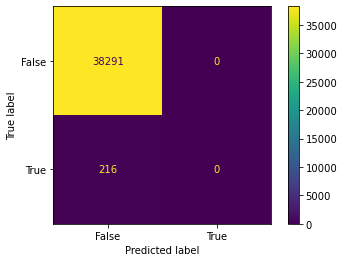

In [15]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Ok... clearly I have more work to do on this matrix since the confusion matrix has a whopping 0 in the "True and True" box. Apparently the model is not very helpful in predicting drug related arrests near parks. I'll plot the variables of importance as well here just to start getting an idea of where to go next.

Text(0, 0.5, 'Mean decrease in impurity')

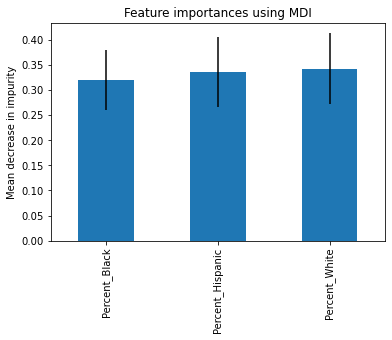

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx 

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


Text(0, 0.5, 'Mean decrease in impurity')

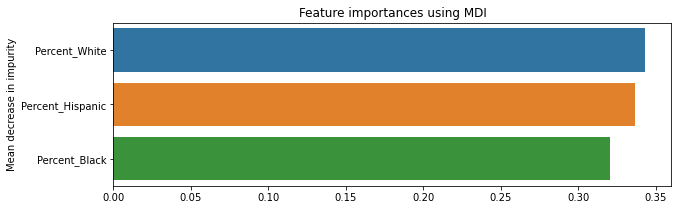

In [17]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

What about how the race of the census tract might factor into predicting a drug related offense in general? I'll try to just look at the drug arrests factoring in race data overall to see what it might show.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['Percent_Black','Percent_Hispanic','Percent_White']
yvar = 'drug_offense'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

115519 115519
38507 38507


In [19]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))



38507 38507


[[35873    94]
 [ 2480    60]]
Accuracy score: 0.9332
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     35967
        True       0.39      0.02      0.04      2540

    accuracy                           0.93     38507
   macro avg       0.66      0.51      0.50     38507
weighted avg       0.90      0.93      0.90     38507



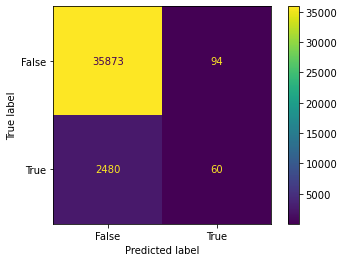

In [20]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

So this is a bit more valuable, it seems as if there is a racial component to predicting a drug related arrest for the overall arrest data. The three racial categories are pretty similarly ranked, but the percent of the population that is Black is the strongest variable for predicting a drug related arrest. These are plotted below. Next, I'll include the parks (proximity of the arrest to parks and park names) into my model. 

Text(0, 0.5, 'Mean decrease in impurity')

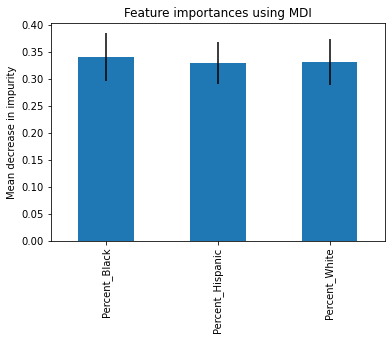

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx 

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


Text(0, 0.5, 'Mean decrease in impurity')

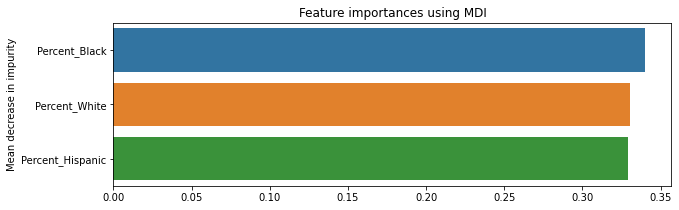

In [22]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

### Predicting Drug Related Arrests

Next, we'll bring in park location and distance to parks (rather than combining both into a boolean column) to explore if race demographics, park location, and proximity to a park factor into the prediction of a drug related offense.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars =  ['Percent_Black','Percent_Hispanic','Percent_White','hundred_m', 'dist_to_park',]
yvar = 'drug_offense'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )


115515 115515
38506 38506


In [24]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))

38506 38506


[[35061   845]
 [ 1808   792]]
Accuracy score: 0.9311
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     35906
        True       0.48      0.30      0.37      2600

    accuracy                           0.93     38506
   macro avg       0.72      0.64      0.67     38506
weighted avg       0.92      0.93      0.92     38506



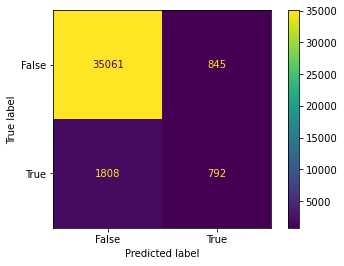

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Text(0, 0.5, 'Mean decrease in impurity')

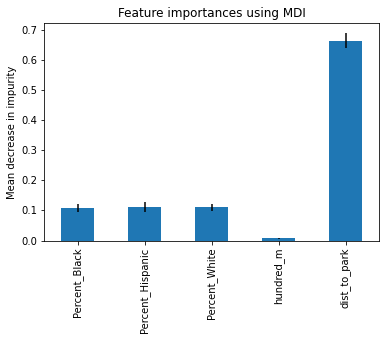

In [26]:
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Text(0, 0.5, 'Mean decrease in impurity')

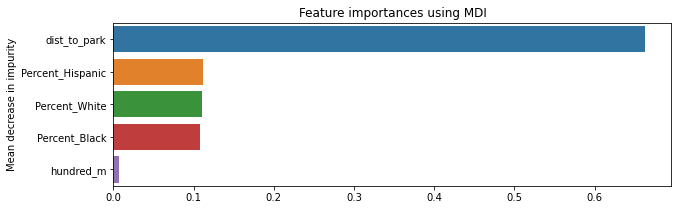

In [27]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [28]:
#len(y_pred) 
y_test
y_test_df = pd.DataFrame(y_test)
y_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38506 entries, 28346 to 104541
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   drug_offense  38506 non-null  bool 
dtypes: bool(1)
memory usage: 338.4 KB


In [29]:
y_test_df['y_pred']=y_pred
y_test_df

drug_offense  y_pred
28346          False   False
21381          False   False
72469          False    True
70103          False   False
57025          False   False
...              ...     ...
78529          False   False
25383          False   False
29929          False   False
113713         False   False
104541         False   False

[38506 rows x 2 columns]

In [30]:
#y_test_df.reset_index(inplace=True)

In [31]:
df_to_fit

Percent_Black  Percent_Hispanic  Percent_White hundred_m  \
0               49.00         35.075758      12.378788     False   
1               49.00         35.075758      12.378788     False   
2               49.00         35.075758      12.378788     False   
3               49.00         35.075758      12.378788     False   
4               49.00         35.075758      12.378788     False   
...               ...               ...            ...       ...   
155514          34.25         32.333333      11.250000     False   
155515          34.25         32.333333      11.250000     False   
155516          34.25         32.333333      11.250000     False   
155517          34.25         32.333333      11.250000     False   
155518          34.25         32.333333      11.250000     False   

        dist_to_park  drug_offense  
0        2576.874201         False  
1        2491.364333         False  
2        2491.364333         False  
3        2491.364333         False  
4        2491.364333         False  
...              ...           ...  
155514   3819.104503         False  
155515   4116.509794         False  
155516   4116.509794         False  
155517   4116.509794         False  
155518   3983.743178         False  

[154021 rows x 6 columns]

In [32]:
y_pred_df=pd.Series(y_pred, index=y_test.index)
y_pred_df.name = 'y_pred_df'
y_pred_df=y_pred_df.to_frame()
y_pred_df

y_pred_df
28346       False
21381       False
72469        True
70103       False
57025       False
...           ...
78529       False
25383       False
29929       False
113713      False
104541      False

[38506 rows x 1 columns]

In [33]:
df_to_fit = df_to_fit.join(y_pred_df)
df_to_fit


Percent_Black  Percent_Hispanic  Percent_White hundred_m  \
0               49.00         35.075758      12.378788     False   
1               49.00         35.075758      12.378788     False   
2               49.00         35.075758      12.378788     False   
3               49.00         35.075758      12.378788     False   
4               49.00         35.075758      12.378788     False   
...               ...               ...            ...       ...   
155514          34.25         32.333333      11.250000     False   
155515          34.25         32.333333      11.250000     False   
155516          34.25         32.333333      11.250000     False   
155517          34.25         32.333333      11.250000     False   
155518          34.25         32.333333      11.250000     False   

        dist_to_park  drug_offense y_pred_df  
0        2576.874201         False       NaN  
1        2491.364333         False     False  
2        2491.364333         False       NaN  
3        2491.364333         False       NaN  
4        2491.364333         False       NaN  
...              ...           ...       ...  
155514   3819.104503         False       NaN  
155515   4116.509794         False       NaN  
155516   4116.509794         False       NaN  
155517   4116.509794         False       NaN  
155518   3983.743178         False     False  

[154021 rows x 7 columns]

In [34]:
#df_to_fit.merge(y_test_df)

In [35]:
importancesdf = pd.DataFrame(importances)
# turn y_test into a DF, add y_pred onto the DF, and then merge onto the old dataframe 

In [36]:
importancesdf

0
0  0.108360
1  0.111354
2  0.110615
3  0.006910
4  0.662760

In [64]:
# plot distance to park against predicted probabibility 

sns.regplot(x='y_pred_df', y='dist_to_park', data=df_to_fit)

KeyError: 'y_pred_df'

## Predicting Drug Related Arrests by Park

For the last step, we added in the park names as a predicter to try to look at what the top parks are for predicting a drug related offense. 

In [38]:
allgdf.reset_index(inplace=True)

In [39]:
# convert propname (the parks) to a dummy variable

dummies = pd.get_dummies(allgdf.propname, prefix='parkname_')  
print(allgdf.propname.head())
dummies.head()

0    Randall's Island Park
1           Soundview Park
2           Soundview Park
3           Soundview Park
4           Soundview Park
Name: propname, dtype: object


parkname__Alley Pond Park  parkname__Aqueduct Walk  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   

   parkname__Archie Spigner Park  parkname__Arden Woods  \
0                              0                      0   
1                              0                      0   
2                              0                      0   
3                              0                      0   
4                              0                      0   

   parkname__Asphalt Green  parkname__Asser Levy Park  parkname__Astoria Park  \
0                        0                          0                       0   
1                        0                          0                       0   
2                        0                          0                       0   
3                        0                          0                       0   
4                        0                          0                       0   

   parkname__Bailey Playground  parkname__Baisley Pond Park  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   parkname__Battery Park City  parkname__Bayswater Park  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   parkname__Belt Parkway/Shore Parkway  parkname__Bensonhurst Park  \
0                                     0                           0   
1                                     0                           0   
2                                     0                           0   
3                                     0                           0   
4                                     0                           0   

   parkname__Betsy Head Park  parkname__Bloomingdale Park  \
0                          0                            0   
1                          0                            0   
2                          0                            0   
3                          0                            0   
4                          0                            0   

   parkname__Blue Heron Park  parkname__Bowne Park  \
0                          0                     0   
1                          0                     0   
2                          0                     0   
3                          0                     0   
4                          0                     0   

   parkname__Breukelen Ballfields  parkname__Broadway Malls  \
0                               0                         0   
1                               0                         0   
2                               0                         0   
3                               0                         0   
4                               0                         0   

   parkname__Bronx Park  parkname__Bronx River Parkway  \
0                     0                              0   
1                     0                              0   
2                     0                              0   
3                     0                              0   
4                     0                              0   

   parkname__Brookfield Park  parkname__Brooklyn Bridge Park  \
0                          0                               0   
1                          0                               0   
2                          0           

In [40]:
allgdf = allgdf.join(dummies)
allgdf.head()

index               geoid                       name   Total  White  \
0      0  14000US36005000100  Census Tract 1, Bronx, NY  6600.0  817.0   
1      1  14000US36005000100  Census Tract 1, Bronx, NY  6600.0  817.0   
2      2  14000US36005000100  Census Tract 1, Bronx, NY  6600.0  817.0   
3      3  14000US36005000100  Census Tract 1, Bronx, NY  6600.0  817.0   
4      4  14000US36005000100  Census Tract 1, Bronx, NY  6600.0  817.0   

    Black  American Indian and Alaska Native  Asian  Pacific Islander  \
0  3234.0                               27.0  171.0               0.0   
1  3234.0                               27.0  171.0               0.0   
2  3234.0                               27.0  171.0               0.0   
3  3234.0                               27.0  171.0               0.0   
4  3234.0                               27.0  171.0               0.0   

   Other Race  Two or more races  Hispanic  Percent_White  Percent_Black  \
0         0.0               36.0    2315.0      12.378788           49.0   
1         0.0               36.0    2315.0      12.378788           49.0   
2         0.0               36.0    2315.0      12.378788           49.0   
3         0.0               36.0    2315.0      12.378788           49.0   
4         0.0               36.0    2315.0      12.378788           49.0   

   Percent_American_Indian_and_Alaska Native  Percent_Asian  \
0                                   0.409091       2.590909   
1                                   0.409091       2.590909   
2                                   0.409091       2.590909   
3                                   0.409091       2.590909   
4                                   0.409091       2.590909   

   Percent_Pacific_Islander  Percent_Other_Race  Percent_Two_or_more_races  \
0                       0.0                 0.0                   0.545455   
1                       0.0                 0.0                   0.545455   
2                       0.0                 0.0                   0.545455   
3                       0.0                 0.0                   0.545455   
4                       0.0                 0.0                   0.545455   

   Percent_Hispanic                                           geometry  \
0         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   
1         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   
2         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   
3         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   
4         35.075758  MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...   

   index_right arrest_key              arrest_date pd_cd  \
0     150976.0  224175403  2021-02-10T00:00:00.000   779   
1     130404.0  226619645  2021-04-07T00:00:00.000    49   
2     111145.0  228382121  2021-05-19T00:00:00.000    49   
3      71521.0  230246752  2021-06-30T00:00:00.000   792   
4     139979.0  224568514  2021-02-19T00:00:00.000    49   

                          pd_desc  ky_cd                ofns_desc    law_code  \
0  PUBLIC ADMINISTRATION,UNCLASSI  126.0  MISCELLANEOUS PENAL LAW  PL 215510B   
1          U.S. CODE UNCLASSIFIED  995.0    FOR OTHER AUTHORITIES  FOA9000049   
2          U.S. CODE UNCLASSIFIED  995.0    FOR OTHER AUTHORITIES  FOA9000049   
3        WEAPONS POSSESSION 1 & 2  118.0        DANGEROUS WEAPONS  PL 265031B   
4          U.S. CODE UNCLASSIFIED  995.0    FOR OTHER AUTHORITIES  FOA9000049   

  law_cat_cd arrest_boro arrest_precinct jurisdiction_code age_group perp_sex  \
0          F           Q             114                 0     25-44        M   
1        NaN           Q             114                 0     18-24        M   
2        NaN           Q             114                 0     18-24        M   
3          F           Q             114                 0     18-24        M   
4        NaN           Q             114                 0     25-44        M   

        perp_race x_coord_cd y_coo

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars =  (dummies.columns.tolist() + ['Percent_Black','Percent_Hispanic','Percent_White','hundred_m', 'dist_to_park',])
yvar = 'drug_offense'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )


115515 115515
38506 38506


In [42]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))

38506 38506


[[35030   876]
 [ 1801   799]]
Accuracy score: 0.9305
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     35906
        True       0.48      0.31      0.37      2600

    accuracy                           0.93     38506
   macro avg       0.71      0.64      0.67     38506
weighted avg       0.92      0.93      0.92     38506



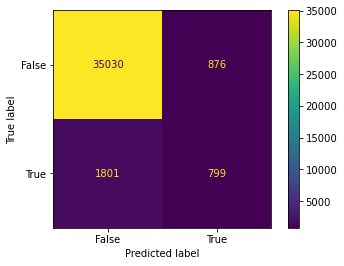

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Text(0, 0.5, 'Mean decrease in impurity')

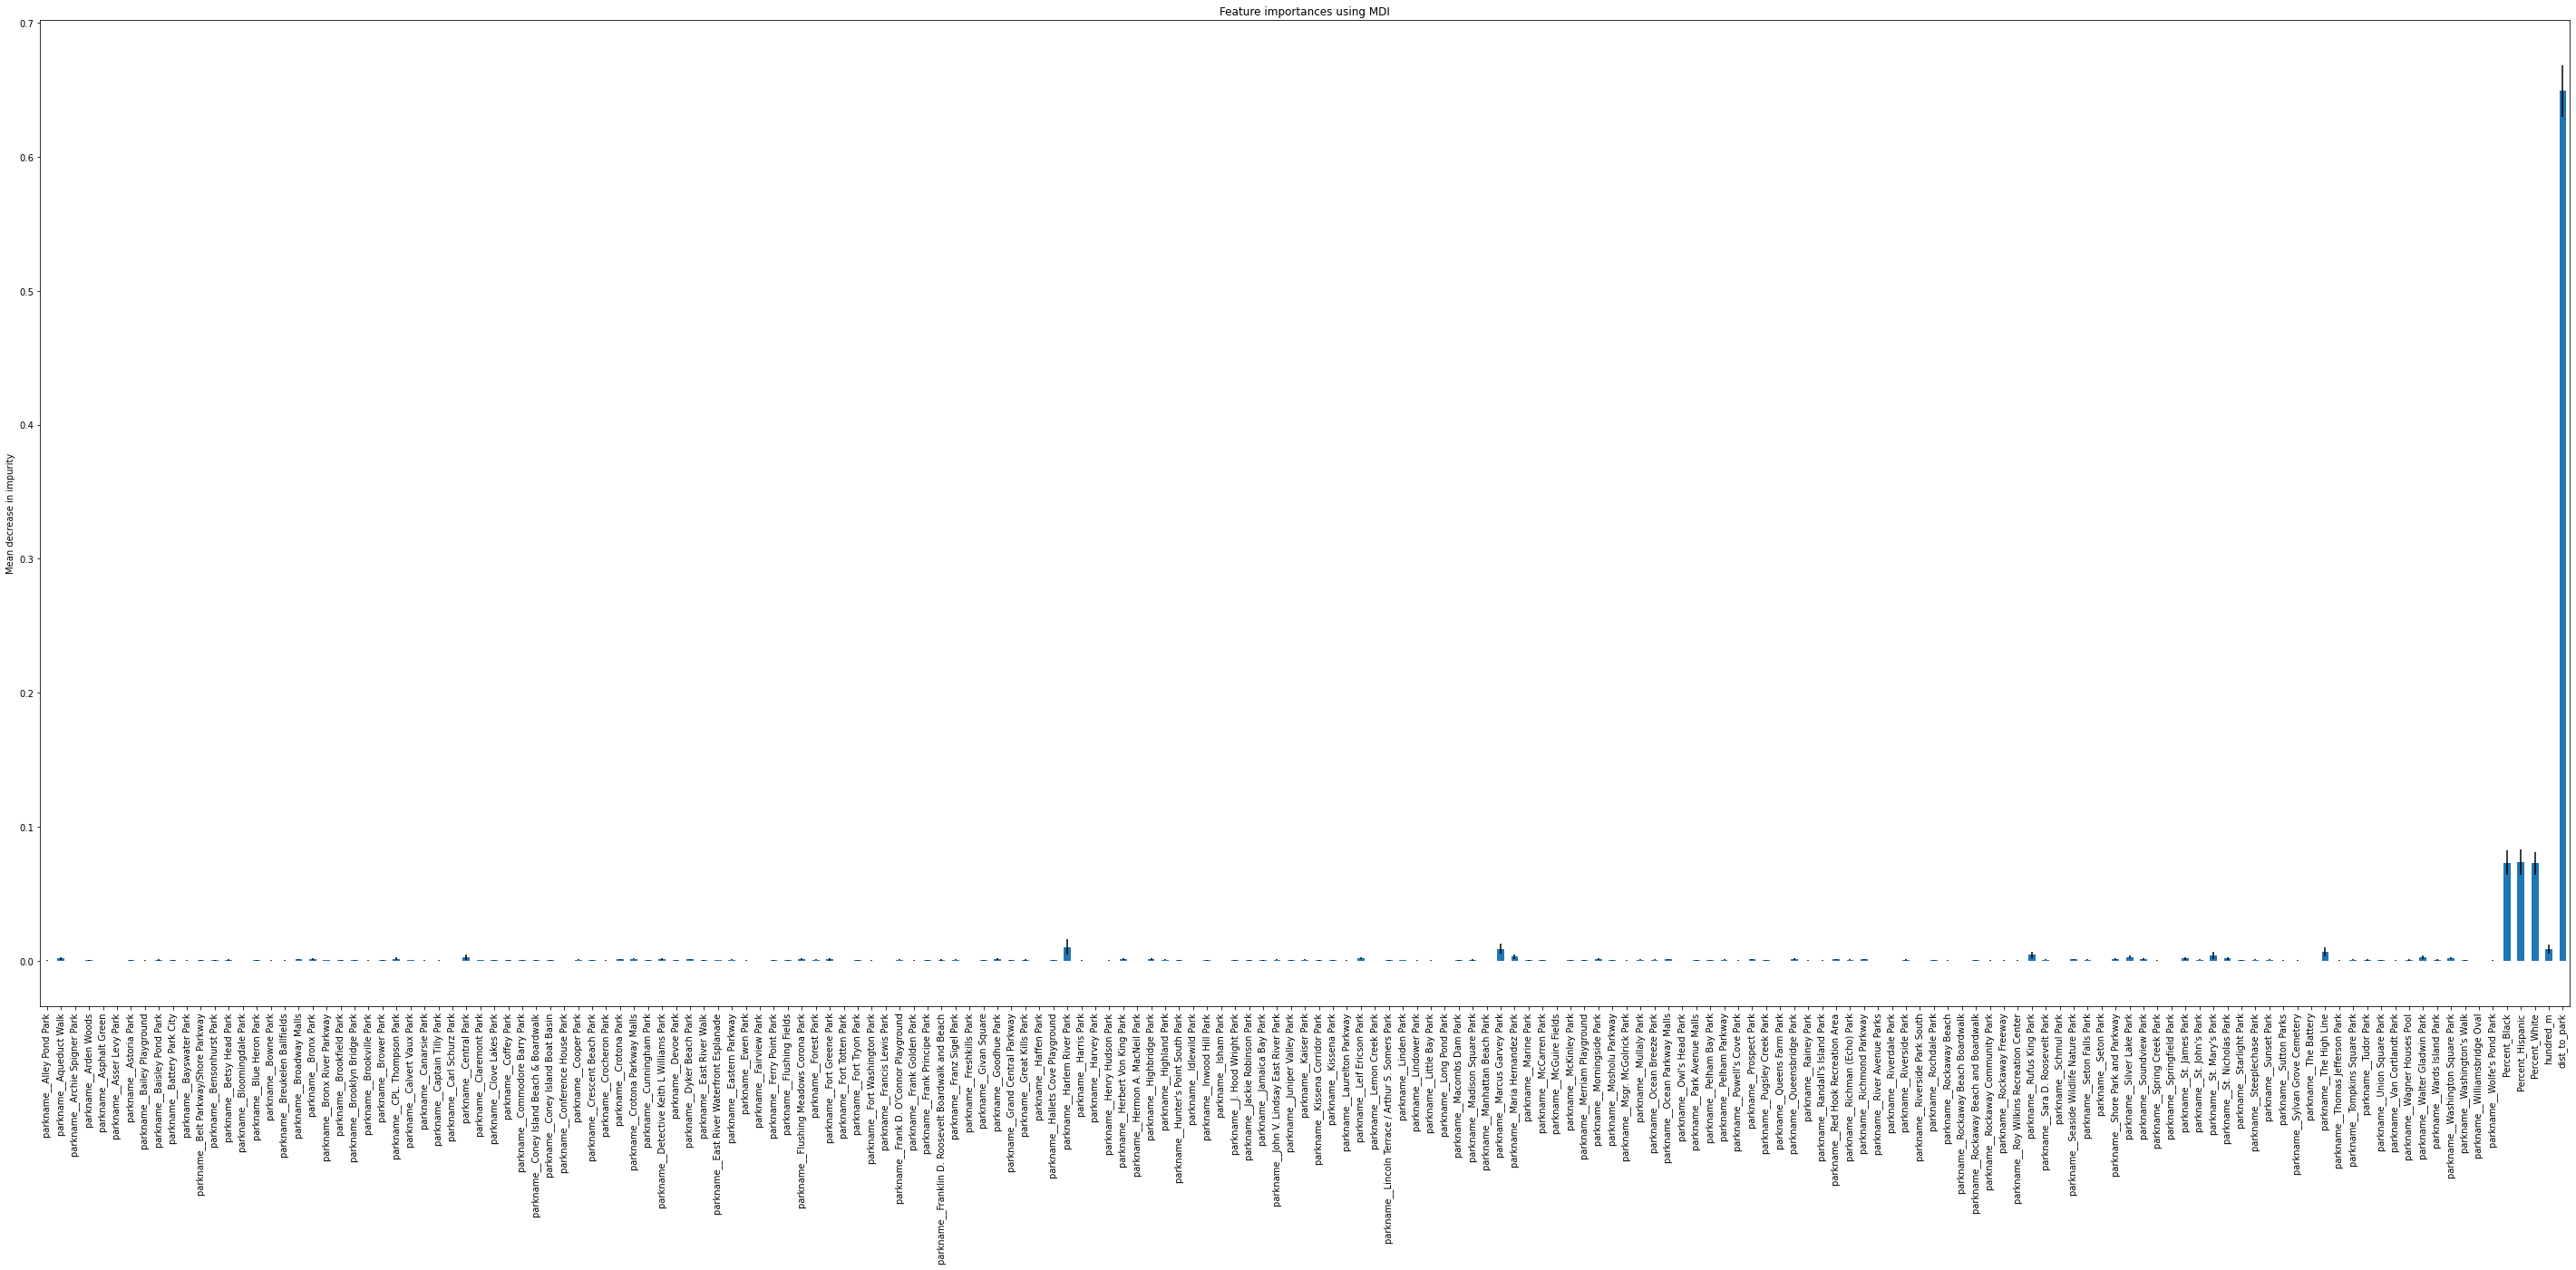

In [44]:
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots(figsize=(50,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Text(0, 0.5, 'Mean decrease in impurity')

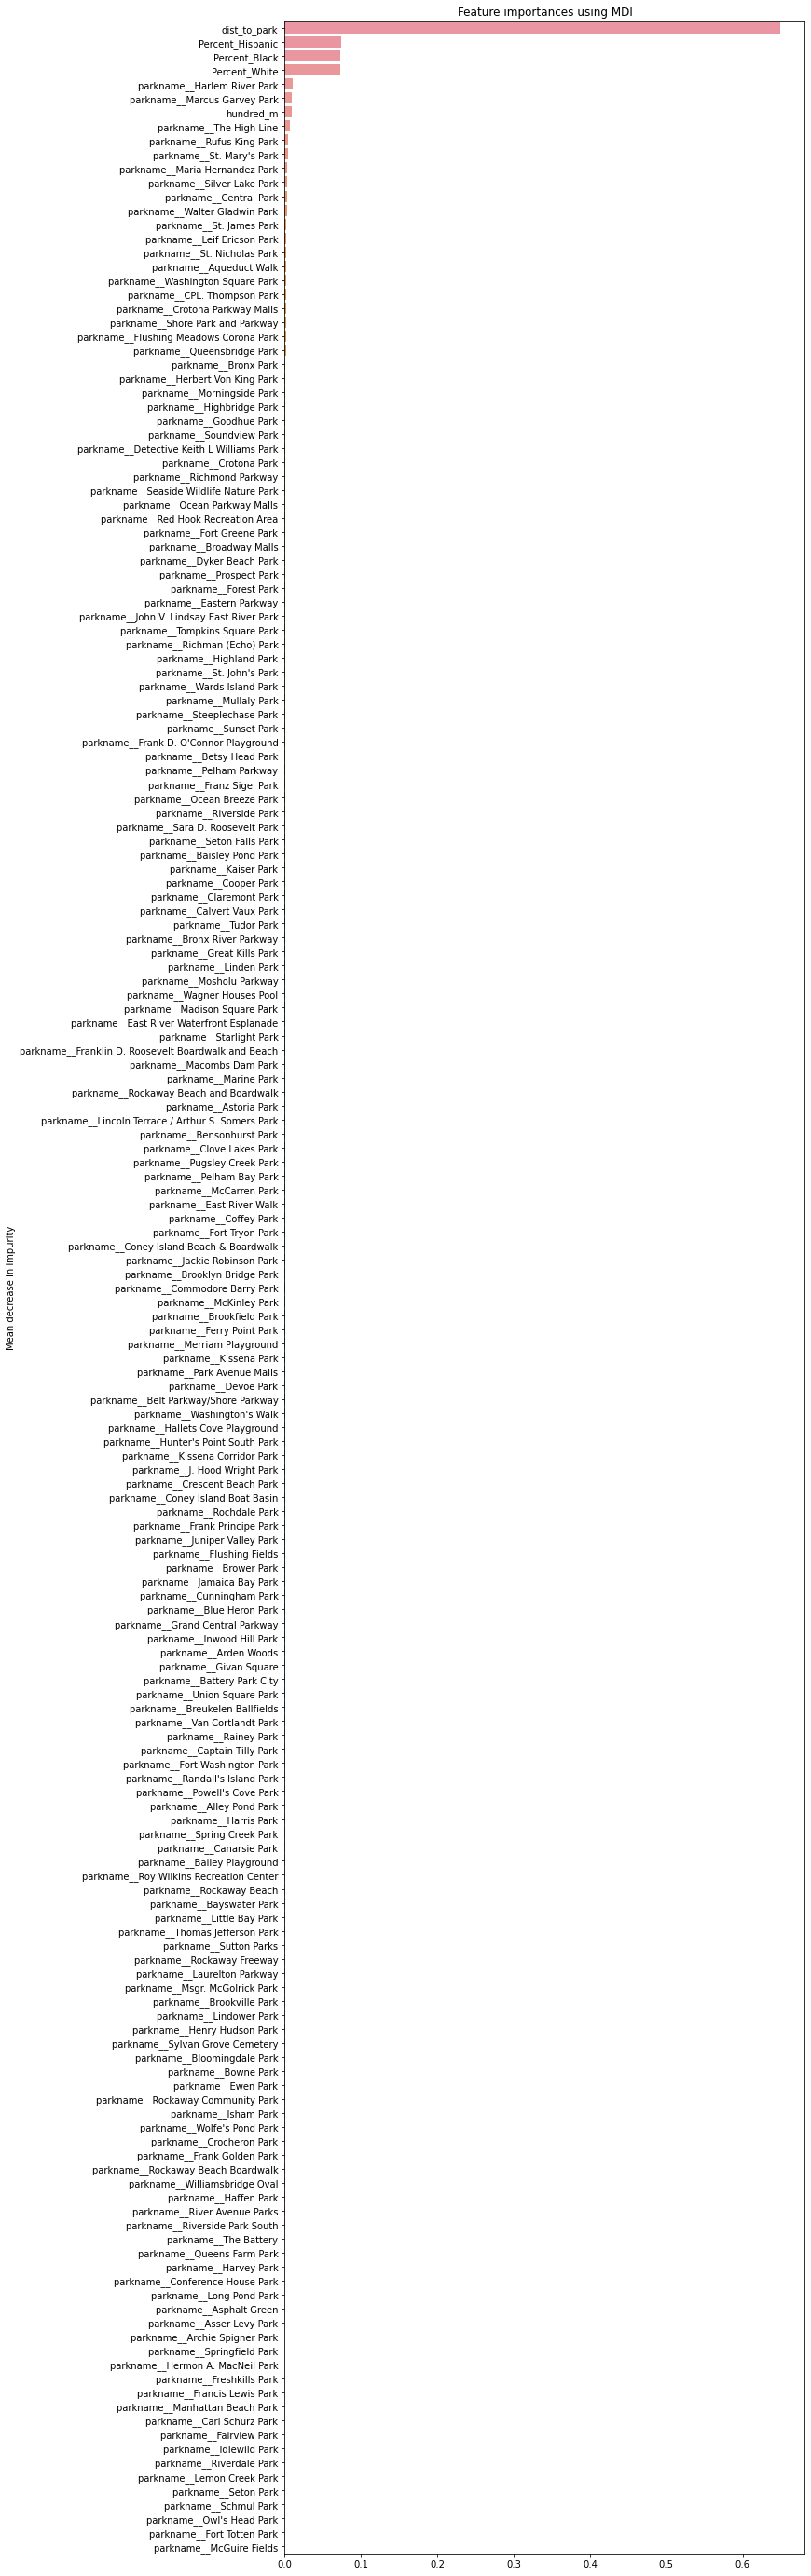

In [45]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,50))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

This is definitely interesting, because the two parks that show up as the greatest predicter of drug related arrests are Harlem River and Marcus Garvey Park, which are both parks in Harlem (a historically Black and lower income borough). The next park down is the High Line, which is in a very wealthy part of New York City (which perhaps means people would be more criminalized). So the location of the park appears to be a valuable metric in predicting whether there will be a drug related arrest, but they appear to be both within some lower income neighborhoods but also on some of the major parks in wealthy areas, like Central Park and the High Line. There is definitely more to explored there in the future! 

Since our analysis pinpointed the parks that had the most arrests in surrounding areas we developed visualizatinos of those 10 locations below. These parks included Harlem River Park in Harlem, Marcus Garvey Park in Harlem, The High Line in Chelsea, Rufus King Park in Jamaica Queens, St. Mary's Park in the Bronx, Maria Hernandez Park in Brooklyn, Silver Lake Park in Staten Island, Central Park in Manhattan, Walter Gladwin Park in the Bronx, and St. James Park in the Bronx.

In [46]:
parkgdf_drugarrests = parkgdf[parkgdf['propname'].isin(['Harlem River Park','Marcus Garvey Park', 'The High Line','Rufus King Park',"St. Mary's Park",'Maria Hernandez Park','Silver Lake Park','Central Park','Walter Gladwin Park','St. James Park'])]
parkgdf_drugarrests

propname retireddate zipcode        acres  \
7     Harlem River Park        None   10039   6.78656566   
18         Central Park        None   10024   0.32263028   
37     Silver Lake Park        None   10301   3.23480323   
46   Marcus Garvey Park        None   10027   0.15435469   
53         Central Park        None   10023   0.39141177   
..                  ...         ...     ...          ...   
825        Central Park        None   10023  39.98214292   
826        Central Park        None   10023  29.32809066   
827        Central Park        None   10023  34.32965642   
832     St. Mary's Park        None   10454  11.47802862   
894        Central Park        None   10023   0.81784579   

                                              location nys_assembly  \
7            Harlem River Dr From E 131 St To W 145 St   70, 68, 71   
18                           91 St & Central Park West           69   
37                           University Pl & Revere St           63   
46           124 St Btwn 5 Ave And Mt Morris Park West           68   
53                                  72 St & East Green           75   
..                                                 ...          ...   
825  North & South Of The Gill, Btwn 79 St Transver...       69, 67   
826                  Sheep Meadow, Center Drive, 72 St       67, 75   
827  72 St Transverse, West Drive, 65 St Transverse...       67, 75   
832  St Mary's St, E 149th St, St Ann's Ave/Surroun...           84   
894              Broadway, 8th Ave, Central Park South           75   

    councildistrict                                        description  \
7                 9                           Harlem River Park Zone 1   
18                6                     Central Park-Safari Playground   
37               49                        Silver Lake Park Playground   
46                9  Marcus Garvey Memorial Park-Marcus Garvey Memo...   
53                6               Central Park-East 72nd St Playground   
..              ...                                                ...   
825               6                            Central Park-The Ramble   
826               6         Central Park-The Mall And Rumsey Playfield   
827               6                          Central Park-Sheep Meadow   
832               8                              St Mary's Park Zone 2   
894               3                       Central Park-Columbus Circle   

    us_congress gispropnum  retired communityboard department  \
7            13       M039    False         110111       M-11   
18           10       M010    False            164       M-13   
37           11       R022    False            501       R-01   
46           13       M058    False            111       M-11   
53           10       M010    False            164       M-13   
..          ...        ...      ...            ...        ...   
825          10       M010    False            164       M-13   
826          10       M010    False            164       M-13   
827          10       M010    False            164       M-13   
832          15       X045    False            201       X-01   
894          10       M010    False            104       M-13   

                    subcategory precinct     omppropid  \
7               Large Park Zone       25     M039-ZN01   
18             Plgd Within Park       22      M010-187   
37             Plgd Within Park      120       R022-04   
46             Plgd Within Park       25       M058-07   
53             Plgd Within Park       22      M010-059   
..                          ...      ...           ...   
825          Flagship Park Zone       22  M010-ZN18&19   
826          Flagship Park Zone        3  M010-ZN12&13   
827          Flagship Park Zone        2  M010-ZN10&11   
832             Large Park Zone       40     X045-ZN02   
894  Sitting Area/Triangle/Mall        2       M010-01   

                          sitename nys_senate borough  \
7         Harlem 

In [47]:
race_Df_web_mercator = race_Df.to_crs(epsg=3857)

Text(0.5, 1.0, 'Top 10 Parks for Predicted Drug Related Arrests in NYC and ACS Data')

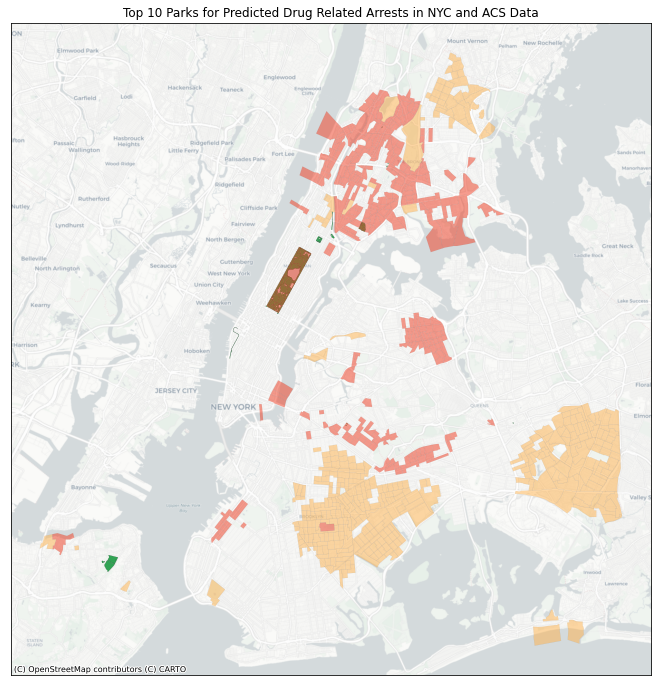

In [48]:
fig, ax = plt.subplots(figsize=(12,12))
parkgdf_drugarrests.to_crs('EPSG:3857').plot(color='#31a354', edgecolor='black',lw=0.1, alpha=1.0, ax=ax)

race_Df_web_mercator[race_Df_web_mercator['Percent_Black']>60].plot(ax=ax, 
                                                                       edgecolor='grey',
                                                                         lw=0.1,
                                                                       alpha=0.5, 
                                                                       color='#feb24c')
race_Df_web_mercator[race_Df_web_mercator['Percent_Hispanic']>60].plot(ax=ax, 
                                                                       edgecolor='grey',
                                                                         lw=0.1,
                                                                       alpha=0.5, 
                                                                       color='#f03b20')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)

ax.set_xticks([])
ax.set_yticks([])
plt.title("Top 10 Parks for Predicted Drug Related Arrests in NYC and ACS Data")

The map above shows ACS data layered with the top parks. This was done in an effort to see what communities might be at risk of having higher policing rates. The darker orange is census tracts where over 60% of the population is Hispanic and the lighter orange shows census tracts where more than 60% of the population is predominiantly Black. This allows us to have a visual of where these parks are located in relation to these neighborhoods. There is some room here to further investigate and analyze arrest data further in these areas. 

It is a bit difficult to see the ten different parks given how small and spread out they are, so lets try to zoom into them below.

In [49]:
parkgdf_drugarrests1 = parkgdf[parkgdf['propname'].isin(['Harlem River Park'])]
parkgdf_drugarrests1

propname retireddate zipcode       acres  \
7    Harlem River Park        None   10039  6.78656566   
550  Harlem River Park        None   10035  1.78474987   
556  Harlem River Park        None   10035  4.59315276   

                                             location nys_assembly  \
7           Harlem River Dr From E 131 St To W 145 St   70, 68, 71   
550  Lexington Ave, Harlem River Dr, N/o 3 Ave Bridge           68   
556       E 128 St, Harlem River Dr, E/o 3 Ave Bridge           68   

    councildistrict               description us_congress gispropnum  retired  \
7                 9  Harlem River Park Zone 1          13       M039    False   
550               9        Each One Teach One          13      M208D    False   
556               8         Harlem River Park          13      M208D    False   

    communityboard department        subcategory precinct  omppropid  \
7           110111       M-11    Large Park Zone       25  M039-ZN01   
550            111       M-11  Neighborhood Park       25   M208D-01   
556            111       M-11  Neighborhood Park       25   M208D-02   

                     sitename nys_senate borough  \
7    Harlem River Park Zone 1         30       M   
550        Each One Teach One     30, 29       M   
556         Harlem River Park         29       M   

                                              geometry  
7    MULTIPOLYGON (((-73.93411 40.81541, -73.93412 ...  
550  MULTIPOLYGON (((-73.93388 40.80697, -73.93389 ...  
556  MULTIPOLYGON (((-73.93336 40.80528, -73.93332 ...

In [50]:
parkgdf_drugarrests2 = parkgdf[parkgdf['propname'].isin(['Marcus Garvey Park'])]
parkgdf_drugarrests2

propname retireddate zipcode       acres  \
46   Marcus Garvey Park        None   10027  0.15435469   
348  Marcus Garvey Park        None   10027  0.31619017   
349  Marcus Garvey Park        None   10027  0.16204716   
604  Marcus Garvey Park        None   10027  6.80352783   
610  Marcus Garvey Park        None   10027  7.08063043   
675  Marcus Garvey Park        None   10027  5.87594793   

                                              location nys_assembly  \
46           124 St Btwn 5 Ave And Mt Morris Park West           68   
348                              E 121st & Madison Ave           68   
349                          5 Ave Nr Madison & 124 St           68   
604  Acropolis, Fire Watchtower And Surrounding Hil...           68   
610  124th St, Mt Morris Park West, 120th St Until ...           68   
675  Madison Ave, btwn 124th St And 120th St Until ...           68   

    councildistrict                                        description  \
46                9  Marcus Garvey Memorial Park-Marcus Garvey Memo...   
348               9        Marcus Garvey Memorial Park-Mt. Morris East   
349               9  Marcus Garvey Memorial Park-Marcus Garvey Memo...   
604               9  Marcus Garvey Memorial Park-Marcus Garvey Park...   
610               9  Marcus Garvey Memorial Park-Marcus Garvey Park...   
675               9  Marcus Garvey Memorial Park-Marcus Garvey Park...   

    us_congress gispropnum  retired communityboard department  \
46           13       M058    False            111       M-11   
348          13       M058    False            111       M-11   
349          13       M058    False            111       M-11   
604          13       M058    False            111       M-11   
610          13       M058    False            111       M-11   
675          13       M058    False            111       M-11   

          subcategory precinct  omppropid                     sitename  \
46   Plgd Within Park       25    M058-07  Marcus Garvey Memorial Park   
348  Plgd Within Park       25    M058-01              Mt. Morris East   
349  Plgd Within Park       25    M058-06  Marcus Garvey Memorial Park   
604   Large Park Zone       25  M058-ZN03    Marcus Garvey Park Zone 3   
610   Large Park Zone       25  M058-ZN01    Marcus Garvey Park Zone 1   
675   Large Park Zone       25  M058-ZN02    Marcus Garvey Park Zone 2   

    nys_senate borough                                           geometry  
46          30       M  MULTIPOLYGON (((-73.94378 40.80593, -73.94352 ...  
348         30       M  MULTIPOLYGON (((-73.94298 40.80315, -73.94295 ...  
349         30       M  MULTIPOLYGON (((-73.94196 40.80523, -73.94195 ...  
604         30       M  MULTIPOLYGON (((-73.94242 40.80507, -73.94242 ...  
610         30       M  MULTIPOLYGON (((-73.94416 40.80626, -73.94417 ...  
675         30       M  MULTIPOLYGON (((-73.94230 40.80550, -73.94236 ...

In [51]:
parkgdf_drugarrests3 = parkgdf[parkgdf['propname'].isin(['The High Line'])]
parkgdf_drugarrests3

propname retireddate     zipcode       acres  \
217  The High Line        None  1001110014  3.73204774   
218  The High Line        None       10001  3.33703737   

                                              location nys_assembly  \
217  Elevated Platform From Washington And Gansevoo...       66, 75   
218  Elevated Platform From W 23rd St And 10th Ave ...           75   

    councildistrict           description us_congress gispropnum  retired  \
217               3  The High Line Zone 1          10       M360    False   
218               3  The High Line Zone 2          10       M360    False   

    communityboard department      subcategory precinct  omppropid  \
217            104       M-16  Large Park Zone       10  M360-ZN01   
218            104       M-16  Large Park Zone       10  M360-ZN02   

                 sitename nys_senate borough  \
217  The High Line Zone 1         27       M   
218  The High Line Zone 2         27       M   

                                              geometry  
217  MULTIPOLYGON (((-74.00481 40.74796, -74.00527 ...  
218  MULTIPOLYGON (((-74.00341 40.74985, -74.00376 ...

In [52]:
parkgdf_drugarrests4 = parkgdf[parkgdf['propname'].isin(['Rufus King Park'])]
parkgdf_drugarrests4

propname retireddate zipcode       acres              location  \
180  Rufus King Park        None   11432  0.45550003  Jamaica Ave & 153 St   

    nys_assembly councildistrict                 description us_congress  \
180           32              24  Rufus King Park Playground           5   

    gispropnum  retired communityboard department       subcategory precinct  \
180       Q023    False            412       Q-12  Plgd Within Park      103   

    omppropid                    sitename nys_senate borough  \
180   Q023-01  Rufus King Park Playground         14       Q   

                                              geometry  
180  MULTIPOLYGON (((-73.80330 40.70407, -73.80330 ...

In [53]:
parkgdf_drugarrests5 = parkgdf[parkgdf['propname'].isin(["St. Mary's Park"])]
parkgdf_drugarrests5

propname retireddate zipcode        acres  \
62   St. Mary's Park        None   10454  13.49023224   
164  St. Mary's Park        None   10455   0.83387628   
315  St. Mary's Park        None   10454    0.3735751   
459  St. Mary's Park        None   10454   2.22849846   
524  St. Mary's Park        None   10455   8.97713912   
832  St. Mary's Park        None   10454  11.47802862   

                                              location nys_assembly  \
62                          Hillside In Center Of Park           84   
164                               Jackson Ave & 144 St           84   
315                         St Marys St & Crimmins Ave           84   
459                            St Ann's Ave & E 147 St           84   
524  Paved Path Btwn St Mary's St And Trinity Ave, ...           84   
832  St Mary's St, E 149th St, St Ann's Ave/Surroun...           84   

    councildistrict                                description us_congress  \
62                8                      St Mary's Park Zone 3          15   
164               8   St Mary's Park-St Mary's Playground East          15   
315               8  St Mary's Park-St Mary's Playground South          15   
459               8   St Mary's Park-St Mary's Playground West          15   
524               8                      St Mary's Park Zone 1          15   
832               8                      St Mary's Park Zone 2          15   

    gispropnum  retired communityboard department       subcategory precinct  \
62        X045    False            201       X-01   Large Park Zone       40   
164       X045    False            201       X-01  Plgd Within Park       40   
315       X045    False            201       X-01  Plgd Within Park       40   
459       X045    False            201       X-01  Plgd Within Park       40   
524       X045    False            201       X-01   Large Park Zone        2   
832       X045    False            201       X-01   Large Park Zone       40   

     omppropid                   sitename nys_senate borough  \
62   X045-ZN03      St Mary's Park Zone 3         29       X   
164    X045-01  St Mary's Playground East         29       X   
315    X045-02       St Mary's Plgd South         29       X   
459    X045-03  St Mary's Playground West         29       X   
524  X045-ZN01      St Mary's Park Zone 1         29       X   
832  X045-ZN02      St Mary's Park Zone 2         29       X   

                                              geometry  
62   MULTIPOLYGON (((-73.91115 40.81349, -73.91115 ...  
164  MULTIPOLYGON (((-73.91072 40.81057, -73.91073 ...  
315  MULTIPOLYGON (((-73.91397 40.81053, -73.91401 ...  
459  MULTIPOLYGON (((-73.91394 40.81231, -73.91391 ...  
524  MULTIPOLYGON (((-73.91043 40.81159, -73.91036 ...  
832  MULTIPOLYGON (((-73.91115 40.81349, -73.91114 ...

In [54]:
parkgdf_drugarrests6 = parkgdf[parkgdf['propname'].isin(['Maria Hernandez Park'])]
parkgdf_drugarrests6

propname retireddate zipcode       acres  \
437  Maria Hernandez Park        None   11237  0.56189324   
552  Maria Hernandez Park        None   11237  0.77777807   

                      location nys_assembly councildistrict  \
437  Knickerbocker St Entrance           53              34   
552        Irving Ave Entrance           53              34   

                                   description us_congress gispropnum  \
437            Maria Hernandez Park Playground           7       B016   
552  Maria Hernandez Park-Maria Hernandez Park           7       B016   

     retired communityboard department       subcategory precinct omppropid  \
437    False            304       B-04  Plgd Within Park       83   B016-01   
552    False            304       B-04  Plgd Within Park       83   B016-02   

                            sitename nys_senate borough  \
437  Maria Hernandez Park Playground         18       B   
552             Maria Hernandez Park         18       B   

                                              geometry  
437  MULTIPOLYGON (((-73.92396 40.70255, -73.92394 ...  
552  MULTIPOLYGON (((-73.92323 40.70338, -73.92299 ...

In [55]:
parkgdf_drugarrests7 = parkgdf[parkgdf['propname'].isin(['Silver Lake Park'])]
parkgdf_drugarrests7

propname retireddate zipcode        acres  \
37   Silver Lake Park        None   10301   3.23480323   
198  Silver Lake Park        None   10301  49.40820335   
243  Silver Lake Park        None   10301   0.09973681   
583  Silver Lake Park        None   10301  57.73172659   

                                              location nys_assembly  \
37                           University Pl & Revere St           63   
198  Forest Av, Victory Blvd, NE of Control Bldg, B...           63   
243            Center Of Zone 2 Closer To Victory Blvd           63   
583  Victory Blvd, Revere St, SW of Control Bldg, B...           63   

    councildistrict                                description us_congress  \
37               49                Silver Lake Park Playground          11   
198              49                    Silver Lake Park Zone 2          11   
243              49  Silver Lake Park-Silver Lake Park Tot Lot          11   
583              49                    Silver Lake Park Zone 1          11   

    gispropnum  retired communityboard department       subcategory precinct  \
37        R022    False            501       R-01  Plgd Within Park      120   
198       R022    False            501       R-01   Large Park Zone        2   
243       R022    False            501       R-01  Plgd Within Park      120   
583       R022    False            501       R-01   Large Park Zone        3   

     omppropid                     sitename nys_senate borough  \
37     R022-04  Silver Lake Park Playground         24       R   
198  R022-ZN02      Silver Lake Park Zone 2         24       R   
243    R022-05     Silver Lake Park Tot Lot         24       R   
583  R022-ZN01      Silver Lake Park Zone 1         24       R   

                                              geometry  
37   MULTIPOLYGON (((-74.10050 40.62735, -74.09966 ...  
198  MULTIPOLYGON (((-74.08997 40.62908, -74.08994 ...  
243  MULTIPOLYGON (((-74.09072 40.62904, -74.09074 ...  
583  MULTIPOLYGON (((-74.09664 40.62881, -74.09664 ...

In [56]:
parkgdf_drugarrests8 = parkgdf[parkgdf['propname'].isin(['Central Park'])]
parkgdf_drugarrests8

propname retireddate zipcode        acres  \
18   Central Park        None   10024   0.32263028   
53   Central Park        None   10023   0.39141177   
60   Central Park        None   10023   0.32011493   
77   Central Park        None   10025   0.30738835   
85   Central Park        None   10023  26.34104271   
..            ...         ...     ...          ...   
820  Central Park        None   10024  22.52065615   
825  Central Park        None   10023  39.98214292   
826  Central Park        None   10023  29.32809066   
827  Central Park        None   10023  34.32965642   
894  Central Park        None   10023   0.81784579   

                                              location nys_assembly  \
18                           91 St & Central Park West           69   
53                                  72 St & East Green           75   
60                                     67 St & 5th Ave           75   
77                                  110 St & Lenox Ave           68   
85          West Drive, Center Drive, 65 St Transverse           75   
..                                                 ...          ...   
820     East Drive, 79 St Transverse, 5th Ave To 86 St           69   
825  North & South Of The Gill, Btwn 79 St Transver...       69, 67   
826                  Sheep Meadow, Center Drive, 72 St       67, 75   
827  72 St Transverse, West Drive, 65 St Transverse...       67, 75   
894              Broadway, 8th Ave, Central Park South           75   

    councildistrict                                     description  \
18                6                  Central Park-Safari Playground   
53                6            Central Park-East 72nd St Playground   
60                6           Central Park-Billy Johnson Playground   
77                6    Central Park-110th St & Lenox Ave Playground   
85                6  Central Park-Heckscher Ballfields & Playground   
..              ...                                             ...   
820               6     Central Park-The Metropolitan Museum Of Art   
825               6                         Central Park-The Ramble   
826               6      Central Park-The Mall And Rumsey Playfield   
827               6                       Central Park-Sheep Meadow   
894               3                    Central Park-Columbus Circle   

    us_congress gispropnum  retired communityboard department  \
18           10       M010    False            164       M-13   
53           10       M010    False            164       M-13   
60           10       M010    False            164       M-13   
77           13       M010    False            164       M-13   
85           10       M010    False            164       M-13   
..          ...        ...      ...            ...        ...   
820          10       M010    False            164       M-13   
825          10       M010    False            164       M-13   
826          10       M010    False            164       M-13   
827          10       M010    False            164       M-13   
894          10       M010    False            104       M-13   

                    subcategory precinct     omppropid  \
18             Plgd Within Park       22      M010-187   
53             Plgd Within Park       22      M010-059   
60             Plgd Within Park       22      M010-048   
77             Plgd Within Park       22      M010-247   
85           Flagship Park Zone       22     M010-ZN06   
..                          ...      ...           ...   
820          Flagship Park Zone        2     M010-ZN26   
825          Flagship Park Zone       22  M010-ZN18&19   
826          Flagship Park Zone        3  M010-ZN12&13   
827          Flagship Park Zone        2  M010-ZN10&11   
894  Sitting Area/Triangle/Mall        2       M010-01   

                              sitename nys_senate borough  \
18                         Safari Plgd         29       M   
53                   East 72nd St Plgd         29     

In [57]:
parkgdf_drugarrests9 = parkgdf[parkgdf['propname'].isin(['Walter Gladwin Park'])]
parkgdf_drugarrests9

propname retireddate zipcode       acres  \
89  Walter Gladwin Park        None   10457  0.75599676   
90  Walter Gladwin Park        None   10457  0.28834136   

                   location nys_assembly councildistrict  \
89    E 175 St & Arthur Ave           86              15   
90  E Tremont & Arthur Aves           86              15   

                                    description us_congress gispropnum  \
89  Walter Gladwin Park-175th Street Playground          15      X010A   
90       Walter Gladwin Park-Tremont Playground          15      X010A   

    retired communityboard department       subcategory precinct omppropid  \
89    False            206       X-06  Plgd Within Park       48  X010A-02   
90    False            206       X-06  Plgd Within Park       48  X010A-01   

                   sitename nys_senate borough  \
89  175th Street Playground         33       X   
90       Tremont Playground         33       X   

                                             geometry  
89  MULTIPOLYGON (((-73.89428 40.84460, -73.89423 ...  
90  MULTIPOLYGON (((-73.89422 40.84614, -73.89422 ...

In [58]:
parkgdf_drugarrests10 = parkgdf[parkgdf['propname'].isin(['St. James Park'])]
parkgdf_drugarrests10

propname retireddate zipcode       acres               location  \
142  St. James Park        None   10468  0.46023241  E 193 St & Jerome Ave   

    nys_assembly councildistrict               description us_congress  \
142           78              14  St James Park Playground          13   

    gispropnum  retired communityboard department       subcategory precinct  \
142       X044    False            207       X-07  Plgd Within Park       52   

    omppropid                  sitename nys_senate borough  \
142   X044-01  St James Park Playground         33       X   

                                              geometry  
142  MULTIPOLYGON (((-73.89816 40.86577, -73.89804 ...

Text(0.5, 1.0, 'Top 10 Parks for Predicted Drug Related Arrests in New York City')

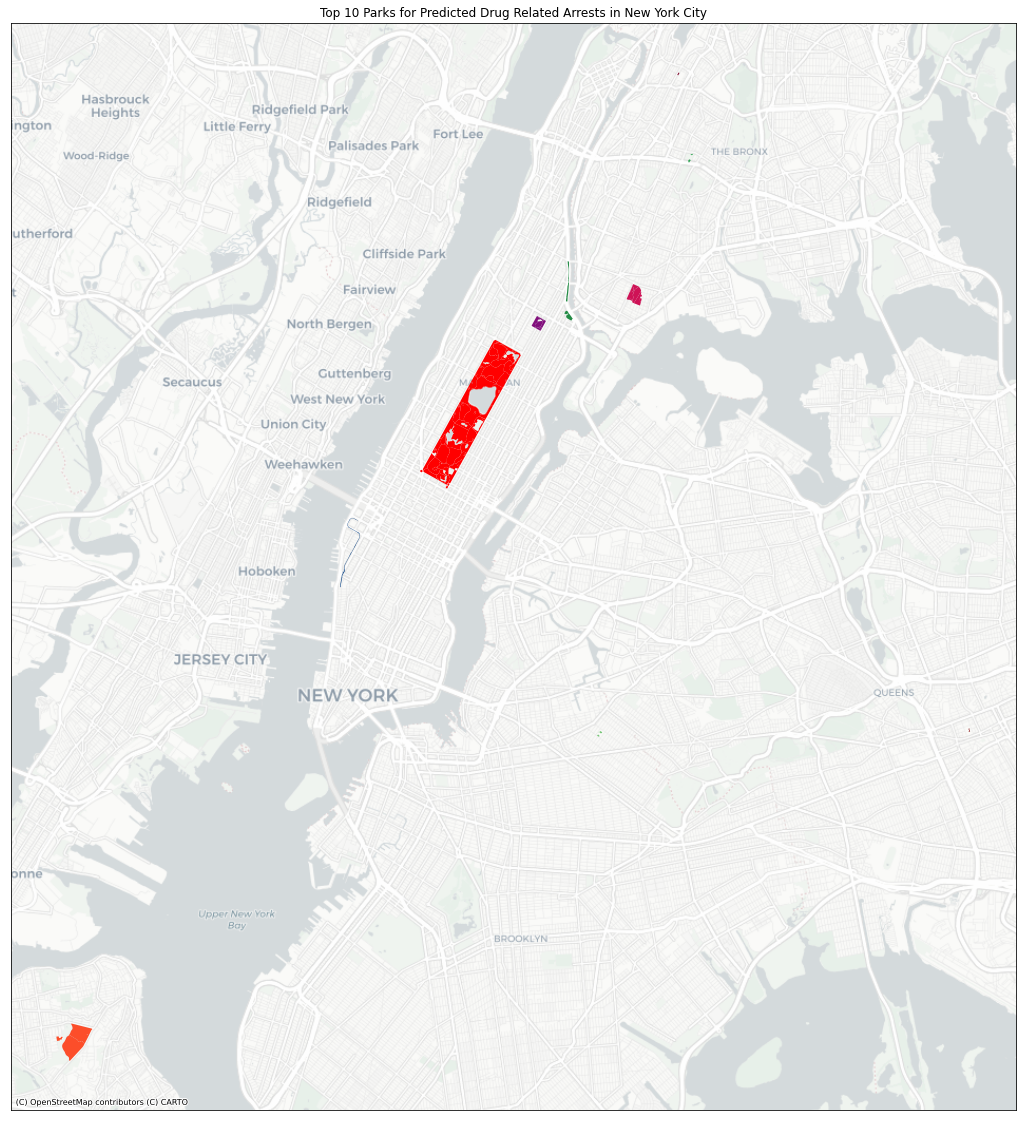

In [59]:
fig, ax = plt.subplots(figsize=(20,20))
parkgdf_drugarrests1.to_crs('EPSG:3857').plot(color='#238b45', alpha=1.0, ax=ax) #green
parkgdf_drugarrests2.to_crs('EPSG:3857').plot(color='#810f7c', alpha=1.0, ax=ax) #purple
parkgdf_drugarrests3.to_crs('EPSG:3857').plot(color='#084081', alpha=1.0, ax=ax) #Navy
parkgdf_drugarrests4.to_crs('EPSG:3857').plot(color='#7f0000', alpha=1.0, ax=ax) #darkred
parkgdf_drugarrests5.to_crs('EPSG:3857').plot(color='#ce1256', alpha=1.0, ax=ax) #redpink
parkgdf_drugarrests6.to_crs('EPSG:3857').plot(color='#78c679', alpha=1.0, ax=ax) #limegreen
parkgdf_drugarrests7.to_crs('EPSG:3857').plot(color='#fc4e2a', alpha=1.0, ax=ax) #orange
parkgdf_drugarrests8.to_crs('EPSG:3857').plot(color='r', alpha=1.0, ax=ax)        #red
parkgdf_drugarrests9.to_crs('EPSG:3857').plot(color='#31a354', alpha=1.0, ax=ax) #lime green
parkgdf_drugarrests10.to_crs('EPSG:3857').plot(color='#800026', alpha=1.0, ax=ax) #velvet

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron, zoom=12)

ax.set_xticks([])
ax.set_yticks([])
plt.title("Top 10 Parks for Predicted Drug Related Arrests in New York City")

These parks are a bit difficult to see, lets try to zoom in and get a better look. Some of the parks in our top ten lists are relatively small compared to Central Park.

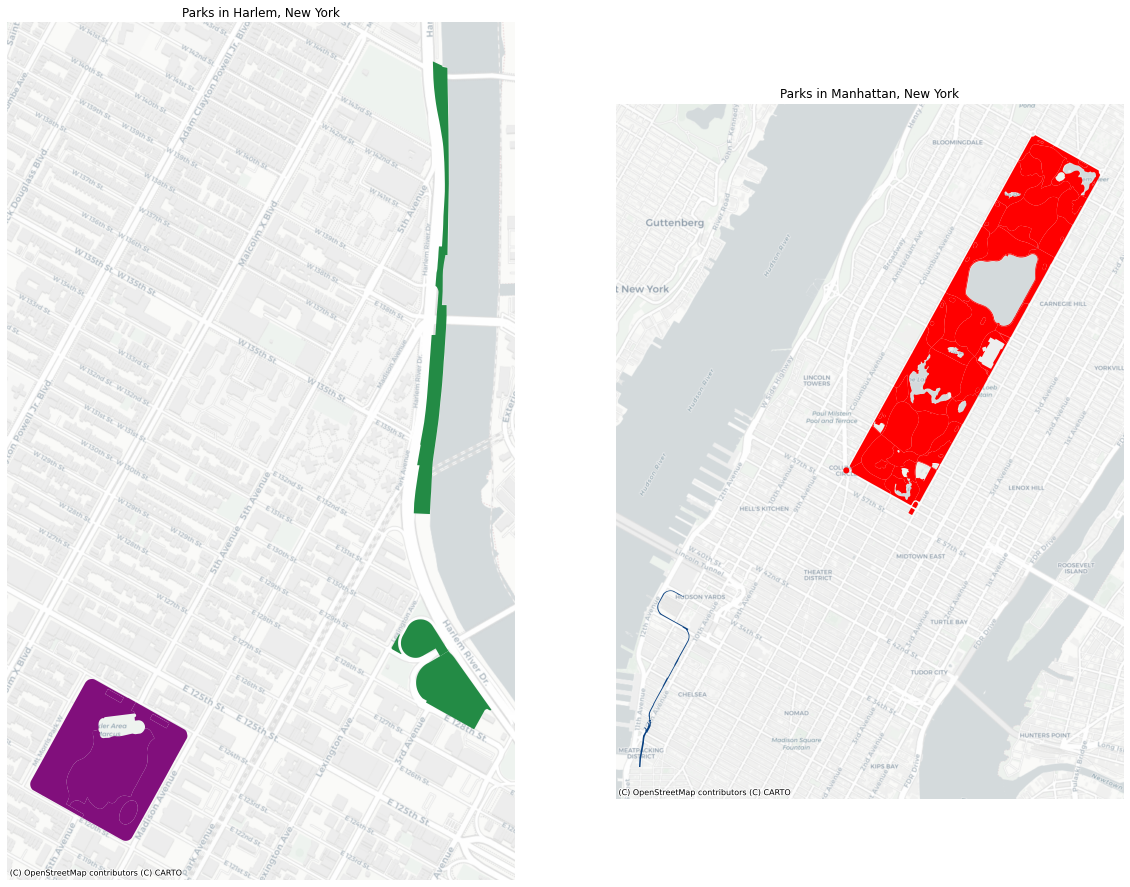

In [60]:
fig, ax = plt.subplots(1,2,figsize=(20,20))

ax1,ax2=ax

ax1.axis('off')
ax1.set_aspect(aspect=2.5)
ax1.set_title("Parks in Harlem, New York")
parkgdf_drugarrests1.to_crs('EPSG:3857').plot(color='#238b45', alpha=1.0, ax=ax1) #green
parkgdf_drugarrests2.to_crs('EPSG:3857').plot(color='#810f7c', alpha=1.0, ax=ax1)

ax2.axis('off')
ax2.set_aspect(aspect=0.5)
ax2.set_title("Parks in Manhattan, New York")
parkgdf_drugarrests3.to_crs('EPSG:3857').plot(color='#084081', alpha=1.0, ax=ax2) #purple
parkgdf_drugarrests8.to_crs('EPSG:3857').plot(color='r', alpha=1.0, ax=ax2)

#basemap
ctx.add_basemap(ax1,source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2,source=ctx.providers.CartoDB.Positron)

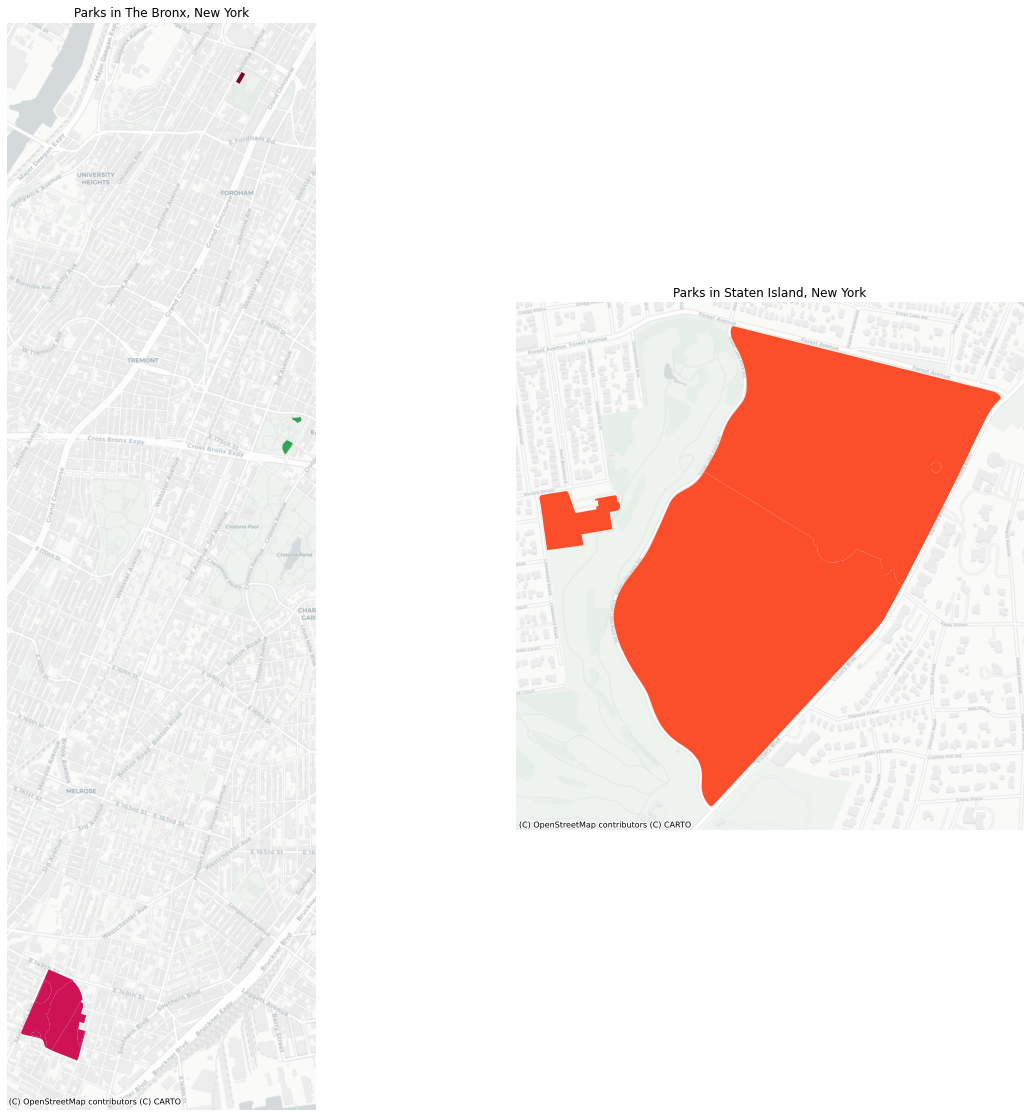

In [61]:
fig, ax = plt.subplots(1,2,figsize=(20,20))

ax1,ax2 = ax

ax1.axis('off')

ax1.set_title("Parks in The Bronx, New York")
parkgdf_drugarrests5.to_crs('EPSG:3857').plot(color='#ce1256', alpha=1.0, ax=ax1)
parkgdf_drugarrests9.to_crs('EPSG:3857').plot(color='#31a354', alpha=1.0, ax=ax1)
parkgdf_drugarrests10.to_crs('EPSG:3857').plot(color='#800026', alpha=1.0, ax=ax1)

ax2.axis('off')
ax2.set_title("Parks in Staten Island, New York")
parkgdf_drugarrests7.to_crs('EPSG:3857').plot(color='#fc4e2a', alpha=1.0, ax=ax2)

#basemap
ctx.add_basemap(ax1,source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2,source=ctx.providers.CartoDB.Positron)

/Users/stephanieandrade/opt/anaconda3/envs/uds/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


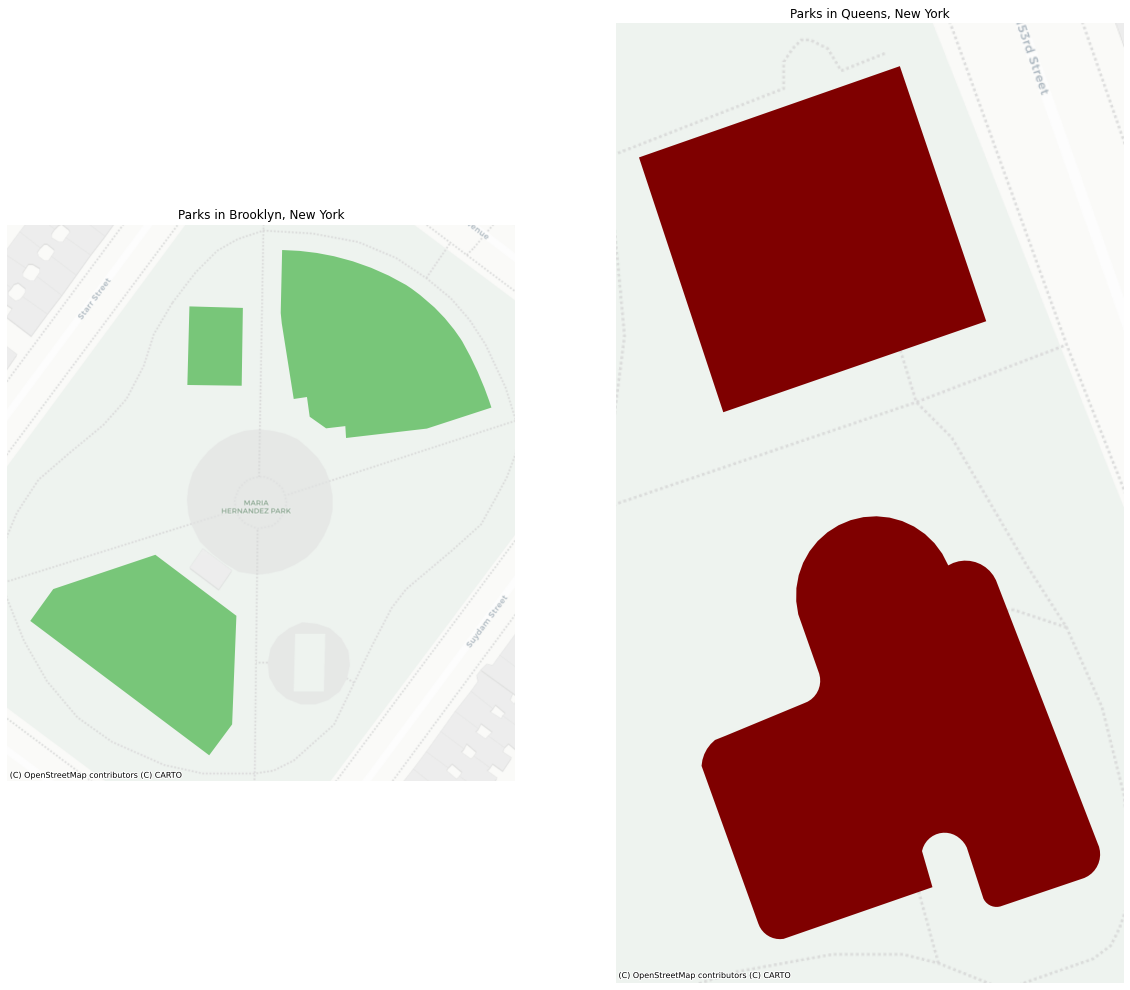

In [62]:
fig, ax = plt.subplots(1,2,figsize=(20,20))

ax1,ax2 = ax

ax1.axis('off')
ax1.set_title("Parks in Brooklyn, New York")
parkgdf_drugarrests6.to_crs('EPSG:3857').plot(color='#78c679', alpha=1.0, ax=ax1) #purple

ax2.axis('off')
ax2.set_title("Parks in Queens, New York")
parkgdf_drugarrests4.to_crs('EPSG:3857').plot(color='#7f0000', alpha=1.0, ax=ax2) #purple

#basemap
ctx.add_basemap(ax1,source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2,source=ctx.providers.CartoDB.Positron)

# Conclusion 

When we first started exploring this relationship between parks and arrests, it was a surprising finding that there is very little difference between the arrests that happen all over New York versus the arrests that happen near parks. Our original hypothesis that more street vendors might be criminalized or that people might be arrested for crimes associated with homelessness was not apparent from our exploration of arrests (see the notebook "Exploratory Analysis of Parks and Arrests" in our GitHub repository). There were some subtle differences (like more traffic and drug related arrests happening within 100m of a park), but nothing very substantial. Apparently being near a park does not impact the type of arrest that is happening and people are not more criminalized for particular activities in public green spaces as we would have expected. 

For our predictive models, we tried to explore whether the racial makeup of the surrounding neighborhood might influence a predicted drug related offense. It does appear as if race is a major predictor for whether a drug related arrest will occur, though interestingly Black, Hispanic, and white percentages were all pretty evenly ranked. The strongest predictor was the distance to the parks, but whether it was closer to a park was less of an indicator. 

Lastly, we looked at if the particular parks will influence the prediction of a drug related offense. After looking at the feature importances, we found that the top 10 parks for predicting a drug related arrest are Harlem River Park, Marcus Garvey Park, The High Line, Rufus King Park, St. Mary's Park, Maria Hernandez Park, Silver Lake Park, Central Park, Walter Gladwin Park, and St. James Park. 

**Future work:** Overall, I would like to go a bit further in exploring this predictive model. What are some other types of arrests that we could have looked at? How else might we be able to explore the types of arrests that happen near parks? What 